In [1]:
import numpy as np
from numpy.lib import stride_tricks

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import Polygon
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import mocalum as mc
import pandas as pd
import xarray as xr
import time

from pyconturb import gen_turb, gen_spat_grid  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions  

In [79]:
def sliding_window_slicing(a, no_items, item_type=0):
    """This method perfoms sliding window slicing of numpy arrays

    Parameters
    ----------
    a : numpy
        An array to be slided in subarrays
    no_items : int
        Number of sliced arrays or elements in sliced arrays
    item_type: int
        Indicates if no_items is number of sliced arrays (item_type=0) or
        number of elements in sliced array (item_type=1), by default 0

    Return
    ------
    numpy
        Sliced numpy array
    """
    if item_type == 0:
        no_slices = no_items
        no_elements = len(a) + 1 - no_slices
        if no_elements <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))
    else:
        no_elements = no_items                
        no_slices = len(a) - no_elements + 1
        if no_slices <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))

    subarray_shape = a.shape[1:]
    shape_cfg = (no_slices, no_elements) + subarray_shape
    strides_cfg = (a.strides[0],) + a.strides
    as_strided = np.lib.stride_tricks.as_strided #shorthand
    return as_strided(a, shape=shape_cfg, strides=strides_cfg)


def _get_max_turbbox_width(ffield_bbox_cfg):
    x_len = ffield_bbox_cfg['x']['max']-ffield_bbox_cfg['x']['min']
    y_len = ffield_bbox_cfg['y']['max']-ffield_bbox_cfg['y']['min']    
    return ((x_len)**2+(y_len)**2)**(.5)
    

def _get_bbox_pts(ffield_bbox_cfg):
    bbox_pts = np.full((4,2), np.nan)
    bbox_pts[0] = np.array([ffield_bbox_cfg['x']['min'], ffield_bbox_cfg['y']['min']])
    bbox_pts[1] = np.array([ffield_bbox_cfg['x']['min'], ffield_bbox_cfg['y']['max']])    
    bbox_pts[2] = np.array([ffield_bbox_cfg['x']['max'], ffield_bbox_cfg['y']['max']])        
    bbox_pts[3] = np.array([ffield_bbox_cfg['x']['max'], ffield_bbox_cfg['y']['min']])            
    
    return bbox_pts


def _rot_matrix(wind_dir):

    azimuth = wind_dir - 90  # it is revers since something is fishy with dot product
    azimuth = np.radians(azimuth) # converts to radians    
    c, s = np.cos(azimuth), np.sin(azimuth)
    R = np.array([[c, s], [-s, c]])
    return R


def _get_turbbbox(ffield_bbox_cfg, wind_dir):
    bbox_pts = _get_bbox_pts(tmp.data.ffield_bbox_cfg)
    
    # Normalize points to be at the coordinate system center
    bbox_pts_norm =bbox_pts - bbox_pts.mean(axis=0)
    
    # Find position of normalized points in future turb box coord sys
    pts_new_cord = bbox_pts_norm.dot(_rot_matrix(wind_dir)) 
    
    # Find minimum turb bounding box
    x_min, y_min = pts_new_cord.min(axis = 0)
    x_max, y_max = pts_new_cord.max(axis = 0)

    tbox_pts = np.full((4,2), np.nan)
    tbox_pts[0] = np.array([x_min, y_min])
    tbox_pts[1] = np.array([x_min, y_max])    
    tbox_pts[2] = np.array([x_max, y_max])        
    tbox_pts[3] = np.array([x_max, y_min])
    
    return tbox_pts


def _get_prob_cords(probing, bbox_pts):
    
    x = probing.x.values[:probing.no_los.values]
    x_norm = x - bbox_pts.mean(axis=0)[0]
    y = probing.y.values[:probing.no_los.values]
    y_norm = y - bbox_pts.mean(axis=0)[1]
    
    return x_norm,y_norm

In [91]:
koshava_xyz = [0, 0, 0]
no_scans = 10000
# wind field setup
ref_height = 100      # power law reference height
meas_height = 100 
shear_exponent = 0.2  # power law shear exponent
wind_speed = 10       # wind speed at referenec height
wind_dir = 340        # wind direction
w = 0

# beam steering setup
distance = 1000   # meter
elevation = np.degrees(np.arcsin(meas_height / distance))
angular_res = 1   # degree
azimuth_mid = 0   # central azimuth angle
sector_size = 90  # degree
scan_speed = 1    # degree.s^-1
max_speed = 50    # degree.s^-1
max_acc = 100     # degree.s^-2

# Uncertainty terms
no_sim = 10000 # number of simulations
corr_coef = 0   # correlation coefficient
mu = 0         # we assume no systematic uncertainty
azim_std = 0.1 # degrees
elev_std = 0.1 # degrees
dis_std = 10   # meters
rad_std = 0.1  # m.s-1  In [23]:  

tmp = mc.Mocalum()
tmp.x_res = tmp.y_res = 10
  
tmp.set_ivap_probing(koshava_xyz, sector_size, azimuth_mid, angular_res, elevation, distance, 
                    no_scans, scan_speed, max_speed,max_acc)

tmp.gen_unc_contributors(corr_coef)
tmp.gen_plaw_ffield(wind_speed, wind_dir, w, ref_height, shear_exponent)
tmp.calc_los_speed()
tmp.reconstruct_wind()


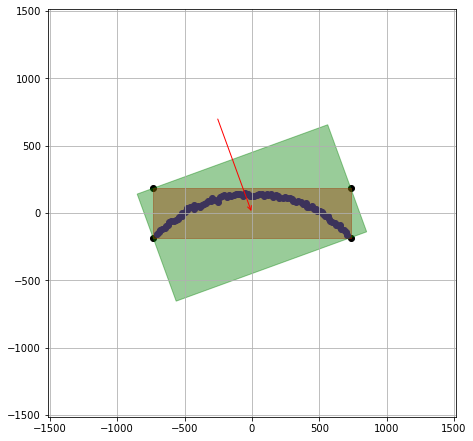

In [92]:
# polygon = Polygon(bbox_pts_norm,alpha=0.4, color='black')
diag = _get_max_turbbox_width(tmp.data.ffield_bbox_cfg)
bbox_pts = _get_bbox_pts(tmp.data.ffield_bbox_cfg)
bbox_pts_norm = bbox_pts - bbox_pts.mean(axis=0)

x_cords, y_cords = _get_prob_cords(tmp.data.probing, bbox_pts)

tbox_pts = _get_turbbbox(tmp.data.ffield_bbox_cfg, wind_dir)

# coordinates in turbox coord sys
pts_new_cord = bbox_pts_norm.dot(_rot_matrix(wind_dir))

wind_dir_pt = mc.utils.spher2cart(wind_dir,0,diag/2)[:2]
bbox = Polygon(bbox_pts_norm,alpha=0.4, color='red')
tbox = Polygon(tbox_pts.dot(_rot_matrix(-wind_dir)),alpha=0.4, color='green')
# tbox2 = Polygon(tbox_pts.dot(_rot_bbox(wind_dir)),alpha=0.4, color='yellow')

# polygon = Polygon(bbox_pts.dot(R))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()
ax.add_patch(bbox)
ax.add_patch(tbox)

plt.scatter(bbox_pts_norm[:,0],bbox_pts_norm[:,1], c="black")
plt.scatter(x_cords,y_cords, c="blue")
ax.set_aspect('equal')
ax.annotate("", xy=(wind_dir_pt[0], wind_dir_pt[1]), xytext=(0, 0),arrowprops=dict(arrowstyle="<-",color='red'))

ax.set_xlim(-diag,diag)
ax.set_ylim(-diag,diag)
plt.show()

In [88]:
tbox_pts

array([[-181.8320238 , -731.94898946],
       [-181.8320238 ,  731.94898946],
       [ 181.8320238 ,  731.94898946],
       [ 181.8320238 , -731.94898946]])

In [90]:
bbox_pts_norm

array([[-731.94898946, -181.8320238 ],
       [-731.94898946,  181.8320238 ],
       [ 731.94898946,  181.8320238 ],
       [ 731.94898946, -181.8320238 ]])

In [453]:
a = np.array([1, 2, 3, 4, 5, 6, 7])

a = np.array([np.arange(1,15),np.arange(1,15)]).transpose()


as_strided = np.lib.stride_tricks.as_strided


array([[                   1,                    2,                    3],
       [                   4,                    5,                    6],
       [                   7,                    8,                    9],
       [    1407374883553288,                    2,                    2],
       [                   8,                   16, -2305834245875262183]])

In [456]:
a = np.arange(1,10).reshape(3,3)

a.strides
a

np.lib.stride_tricks.as_strided(a, shape=(5,3), strides=a.strides)

array([[               1,                2,                3],
       [               4,                5,                6],
       [               7,                8,                9],
       [1465873313461358,                0,       5036803920],
       [              -4,               -1,                0]])

In [4]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))




In [73]:
x = np.arange(100).reshape([4, 5,5])

x

x.strides



(200, 40, 8)

In [49]:
(x.strides[0],) + x.strides

(40, 40, 8)

In [70]:


tmp_array = np.empty((10000, 5,5))

tmp_array.strides

(200, 40, 8)

In [65]:
tmp_array.dtype

dtype('int64')

In [54]:
tmp_array

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [151]:
a = np.arange(10)

In [141]:
len(a)

sliding_window_slicing(a, 5)

array([[[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]]])

In [153]:
sliding_window_slicing_alt(a, 2)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
       [1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [99]:
x.shape[1:]

xslided = _sliding_window_slicing(x,1)
xslided.shape


(4, 1, 5, 5)

In [ ]:
for no_elements in range(0,1000):
    print(len(1)

In [145]:
def sliding_window_slicing(a, no_items, item_type=0):
    """This method perfoms sliding window slicing of numpy arrays

    Parameters
    ----------
    a : numpy
        An array to be slided in subarrays
    no_items : int
        Number of sliced arrays or elements in sliced arrays
    item_type: int
        Indicates if no_items is number of sliced arrays (item_type=0) or
        number of elements in sliced array (item_type=1), by default 0

    Return
    ------
    numpy
        Sliced numpy array
    """
    if item_type == 0:
        no_slices = no_items
        no_elements = len(a) + 1 - no_slices
        if no_elements <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))
    else:
        no_elements = no_items                
        no_slices = len(a) - no_elements + 1
        if no_slices <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))

    subarray_shape = a.shape[1:]
    shape_cfg = (no_slices, no_elements) + subarray_shape
    strides_cfg = (a.strides[0],) + a.strides
    as_strided = np.lib.stride_tricks.as_strided #shorthand
    return as_strided(a, shape=shape_cfg, strides=strides_cfg)



def sliding_window_slicing_old(a, no_elements):
    """This method perfoms sliding window slicing of numpy arrays

    Parameters
    ----------
    a : numpy
        An array to be slided in subarrays
    no_elements : int
        Number of elements in sliced array

    Return
    ------
    numpy
        Sliced numpy array
    """
    no_slices = len(a) - no_elements + 1 
    if no_slices <=0:
        raise ValueError('Sliding slicing not possible, no_elements is larger than ' + str(len(a)))
    subarray_shape = a.shape[1:]
    shape_cfg = (no_slices, no_elements) + subarray_shape
    strides_cfg = (a.strides[0],) + a.strides
    as_strided = np.lib.stride_tricks.as_strided #shorthand
    return as_strided(a, shape=shape_cfg, strides=strides_cfg)
    
# shape[-1]

    

# # from https://stackoverflow.com/questions/53097952/how-to-understand-numpy-strides-for-layman
# # pay attention on how one getting strides!
# no_rows = 2
# strides = (x.strides[0],) + x.strides

# strided_a = stride_tricks.as_strided(x, shape=(no_slices, no_rows, 5,5), strides=strides)
# strided_a

In [3]:
# pulls bbox corners

x_bb_min=tmp.data.ffield_bbox_cfg['x']['min']
x_bb_max=tmp.data.ffield_bbox_cfg['x']['max']
y_bb_min=tmp.data.ffield_bbox_cfg['y']['min']
y_bb_max=tmp.data.ffield_bbox_cfg['y']['max']
z_bb_min=tmp.data.ffield_bbox_cfg['z']['min']
z_bb_max=tmp.data.ffield_bbox_cfg['z']['max']
x_bb_c=x_bb_min+(x_bb_max-x_bb_min)/2
y_bb_c=y_bb_min+(y_bb_max-y_bb_min)/2
w_tbox=((x_bb_max-x_bb_min)**2+(y_bb_max-y_bb_min)**2)**(.5)

In [33]:
w_tbox

1508.122369153815

In [18]:
######### Turbulence box code starts here ###################################
### input ##### x = longitudian y =lateral z= same
x_dens=300 #max 60 on my dell
y_dens=5
z_dens=3
dt_in=2 #max 10 on my dell
T_in=x_dens*dt_in
u_ref_in=10
wdir=330

###############
y = np.linspace(-w_tbox/2, w_tbox/2, y_dens)  # 11 lateral points from -50 to 50 (center @ 0)
z = np.linspace(z_bb_min, z_bb_max, z_dens) # 13 vertical points from 40 to 160 (center @ 100)

spat_df = gen_spat_grid(y, z)

turb_df = gen_turb(spat_df, T=2*T_in, dt=dt_in, u_ref=u_ref_in)

x=np.linspace(-T_in*u_ref_in,0, x_dens) #dt_in number of longitudinal points from 0 m to T_in*u_ref_in meters
# xs, ys, zs, = np.meshgrid(x, y, z)
# xs3=np.repeat(xs, 3, axis=2)
# results=np.array(xs3).flatten() 

# creating 3D gen spat usying modified jenny function
comps=[0, 1, 2]
_spat_rownames = ['k', 'x', 'y', 'z']
xs,ys, zs = np.meshgrid(x, y, z)  # make a 3d meshgrid
ks = np.array(comps, dtype=int)  # sanitizing
col_names = [f'{"uvw"[k]}_p{ip}' for ip in range(xs.size) for k in ks]
# spat_arr = np.c_[np.tile(comps, xs.size),
#                   np.repeat(np.c_[xs.ravel(), ys.T.ravel(), zs.T.ravel()],
#                             ks.size, axis=0)].T  # create array using numpy
spat_arr = np.c_[np.tile(comps, xs.size),
                  np.repeat(np.c_[xs.transpose(1,0,2).ravel(),ys.transpose(1,0,2).ravel(),zs.transpose(0,1,2).ravel()],
                            ks.size, axis=0)].T
spat_df3d=pd.DataFrame(spat_arr, index=_spat_rownames, columns=col_names)


# spat_df.loc['x']=np.array(xs3).flatten() 

# adapting turb_df to 3D (frozen turbulence assumption)
turb3d=turb_df.values # df to numpy to make things easier
temp=np.full((x_dens, x_dens*turb3d.shape[1]), np.nan)
for rown in range(x_dens):
    temp[rown]=turb3d[rown:rown+x_dens,:].ravel() 

for rown in range(temp.shape[0]): #appending 3D turbulence to 3D grid
    spat_df3d.loc[turb_df.index[rown],:] = temp[rown,:]
# del temp
#defying rotation matrix
theta = np.radians(wdir-270)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c))) # or x = pd.DataFrame(data=R,index=['X','Y'])

#trying to rotate turbulence box along wind direction
xy_df=spat_df3d.loc[['x','y']].transpose()
p =xy_df.values
rotated_array = p.dot(R)
rotated_array[:,0]=rotated_array[:,0]+x_bb_c+w_tbox/2*np.cos(theta)
rotated_array[:,1]=rotated_array[:,1]+y_bb_c-w_tbox/2*np.sin(theta)
mmmm=spat_df3d.loc['z'].transpose().values
rotated_array=np.concatenate((rotated_array,mmmm[:,None]),axis=1)

In [47]:
xy_df

,x,y
u_p0,-6000.0,-754.061185
v_p0,-6000.0,-754.061185
w_p0,-6000.0,-754.061185
u_p1,-6000.0,-754.061185
v_p1,-6000.0,-754.061185
...,...,...
v_p4498,0.0,754.061185
w_p4498,0.0,754.061185
u_p4499,0.0,754.061185
v_p4499,0.0,754.061185


In [28]:
spat_df3d.

,u_p0,v_p0,w_p0,u_p1,v_p1,w_p1,u_p2,v_p2,w_p2,u_p3,...,w_p4496,u_p4497,v_p4497,w_p4497,u_p4498,v_p4498,w_p4498,u_p4499,v_p4499,w_p4499
k,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,...,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000
x,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,-6000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
y,-754.061185,-754.061185,-754.061185,-754.061185,-754.061185,-754.061185,-754.061185,-754.061185,-754.061185,-377.030592,...,377.030592,754.061185,754.061185,754.061185,754.061185,754.061185,754.061185,754.061185,754.061185,754.061185
z,91.401601,91.401601,91.401601,100.633039,100.633039,100.633039,109.864477,109.864477,109.864477,91.401601,...,109.864477,91.401601,91.401601,91.401601,100.633039,100.633039,100.633039,109.864477,109.864477,109.864477
0,9.990025,1.017063,-0.110348,9.602300,-2.346109,-1.620956,9.564256,-0.167290,-0.184390,8.222523,...,-0.364785,11.836679,-0.049849,0.424740,11.162591,1.140341,-2.886425,10.576262,-1.039654,1.009553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,10.651234,0.829385,-0.869936,10.229688,-1.205126,0.601371,9.743578,-3.576556,-0.617733,11.591437,...,0.336112,6.009698,0.640577,0.480673,9.021090,-2.842163,0.327854,8.500410,-0.641420,-0.744871
592,11.303291,-0.836046,-1.498124,11.509051,-0.697671,0.616929,11.641171,-2.965294,-0.636922,12.013145,...,0.104011,7.198770,1.090110,0.848680,8.345808,-1.897097,-0.877951,10.268377,-0.807081,-0.646697
594,11.294007,-1.191049,0.065615,12.853170,-0.379885,-0.428679,12.301221,-2.390863,-0.919249,11.457015,...,0.213291,5.946730,2.391923,1.538414,9.116616,-2.907809,-0.924004,9.872254,-0.043221,-0.257821
596,11.819856,-1.726537,-0.150475,11.338694,-0.344695,-0.210357,9.896663,-2.808191,0.228212,11.468255,...,-0.082839,5.318019,1.001779,0.290742,6.911879,0.435650,-0.320893,7.921912,1.923540,0.115111


In [6]:
#interpolating - obtaining final grid
xp=tmp.data.ffield.x.values
yp=tmp.data.ffield.y.values
zp=tmp.data.ffield.z.values
XXX, YYY, ZZZ = np.meshgrid(xp,yp,zp)
XX=XXX.transpose(1,0,2).reshape(-1,XXX.shape[1])
Xp=XX.reshape(-1,1)
YY=YYY.transpose(1,0,2).reshape(-1,YYY.shape[1])
Yp=YY.reshape(-1,1)
ZZ=ZZZ.transpose(0,1,2).reshape(-1,ZZZ.shape[1])
Zp=ZZ.reshape(-1,1)
request=np.concatenate((Xp,Yp,Zp),axis=1)

In [8]:
#rearranging dataframe for xarray conversion
spat_df3d.loc['x']=rotated_array[:,0]
spat_df3d.loc['y']=rotated_array[:,1]
spat_turb=spat_df3d.drop('k')
del spat_df3d

In [9]:
# for u
mask_u_df = spat_turb.columns.str.contains('u_p*')
u_df=spat_turb.loc[:,mask_u_df].T
#interpolation here
points=u_df[['x','y','z']].values
values=u_df.iloc[:,3:].values
u_p=griddata(points, values, request)
u_df1=pd.DataFrame(np.concatenate((request,u_p),axis=1), columns=u_df.columns)
# for u continues
u_df_stacked = u_df1.set_index(['x', 'y', 'z']).stack().reset_index(name='u')
u_df_stacked.columns=u_df_stacked.columns.str.replace('level_3','t')
u_df_multiindex = u_df_stacked.set_index(['x', 'y', 'z', 't'])
del u_df,u_df_stacked
u_ds=u_df_multiindex.to_xarray() #main problem for memory


In [10]:
# for v
mask_v_df = spat_turb.columns.str.contains('v_p*')
v_df=spat_turb.loc[:,mask_v_df].T
#interpolation here
points=v_df[['x','y','z']].values
values=v_df.iloc[:,3:].values
v_p=griddata(points, values, request)
v_df1=pd.DataFrame(np.concatenate((request,v_p),axis=1), columns=v_df.columns)
# for v continues
v_df_stacked = v_df1.set_index(['x', 'y', 'z']).stack().reset_index(name='v')
v_df_stacked.columns=v_df_stacked.columns.str.replace('level_3','t')
v_df_multiindex = v_df_stacked.set_index(['x', 'y', 'z', 't'])
del v_df,v_df_stacked
v_ds=v_df_multiindex.to_xarray() #main problem for memory

In [11]:
# for w
mask_w_df = spat_turb.columns.str.contains('w_p*')
w_df=spat_turb.loc[:,mask_w_df].T
#interpolation here?
points=w_df[['x','y','z']].values
values=w_df.iloc[:,3:].values
w_p=griddata(points, values, request)
w_df1=pd.DataFrame(np.concatenate((request,w_p),axis=1), columns=w_df.columns)
# for w continues
w_df_stacked = w_df1.set_index(['x', 'y', 'z']).stack().reset_index(name='w')
w_df_stacked.columns=w_df_stacked.columns.str.replace('level_3','t')
w_df_multiindex = w_df_stacked.set_index(['x', 'y', 'z', 't'])
del w_df, w_df_stacked
w_ds=w_df_multiindex.to_xarray()

In [12]:
# mergining three separate dataarrays
turb=xr.merge([u_ds, v_ds, w_ds])
turb.attrs['title'] = 'Flow field dataset'
turb.attrs['generator'] = 'pyconturb(Rinker et al.)'

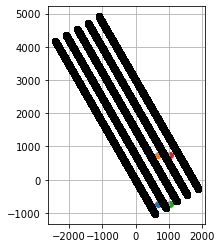

In [13]:
#plotting
plt.plot(spat_turb.loc['x'], spat_turb.loc['y'], 'o', color='black');plt.grid();
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.scatter(x_bb_min,y_bb_min)
plt.scatter(x_bb_min,y_bb_max)
plt.scatter(x_bb_max,y_bb_min)
plt.scatter(x_bb_max,y_bb_max)
plt.scatter(x_bb_c,y_bb_c)